In [1]:
# ライブラリのimport

# NumPy用ライブラリ
import numpy as np

# Matplotlib中のpyplotライブラリのインポート
import matplotlib.pyplot as plt

# matplotlib日本語化対応ライブラリのインポート
import japanize_matplotlib

# pandas用ライブラリ
import pandas as pd

# データフレーム表示用関数
from IPython.display import display

# seaborn
import seaborn as sns

# 表示オプション調整
# NumPy表示形式の設定
np.set_printoptions(precision=3, floatmode="fixed")
# グラフのデフォルトフォント指定
plt.rcParams["font.size"] = 14
# サイズ設定
plt.rcParams["figure.figsize"] = (6, 6)
# 方眼表示ON
plt.rcParams["axes.grid"] = True
# データフレームでの表示精度
pd.options.display.float_format = "{:.3f}".format
# データフレームですべての項目を表示
pd.set_option("display.max_columns", None)

In [2]:
import pymc as pm
import arviz as az

print(f"Running on PyMC v{pm.__version__}")
print(f"Running on ArViz v{az.__version__}")

Running on PyMC v5.25.1
Running on ArViz v0.22.0


In [3]:
# アイリスデータセットの読み込み
df = sns.load_dataset("iris")

# 先頭5行の確認
display(df.head())

#  speciesの分布確認
df["species"].value_counts()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.100,3.500,1.400,0.200,setosa
1,4.900,3.000,1.400,0.200,setosa
2,4.700,3.200,1.300,0.200,setosa
3,4.600,3.100,1.500,0.200,setosa
4,5.000,3.600,1.400,0.200,setosa


species
setosa        50
versicolor    50
virginica     50
Name: count, dtype: int64

In [4]:
# versicolorの行のみ抽出
df1 = df.query('species == "versicolor"')

# sepal_lengthとsepal_widthの列を抽出
X = df1["sepal_length"]
Y = df1["sepal_width"]

Text(0, 0.5, 'sepal_width')

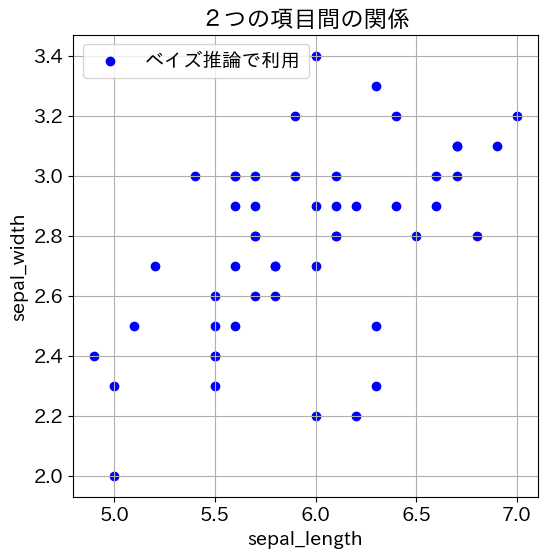

In [5]:
plt.title("２つの項目間の関係")
plt.scatter(X, Y, label="ベイズ推論で利用", c="b", marker="o")
plt.legend()
plt.xlabel("sepal_length")
plt.ylabel("sepal_width")

In [6]:
model1 = pm.Model()

with model1:
    # --------------------------------------------------------------
    # ここでは「単回帰モデル」をベイズ的に書き下ろしている。
    #
    #   観測データ (X_i, Y_i) が与えられているとき、
    #   真の生成過程を
    #
    #       Y_i = α X_i + β + e_i
    #
    #   とみなし、誤差項 e_i を平均 0 の正規分布
    #
    #       e_i ~ Normal(0, ε^2)
    #
    #   に従うと仮定している。
    #   そのとき尤度は
    #
    #       Y_i | α, β, ε ~ Normal(α X_i + β, ε^2)
    #
    #   となる。この α, β, ε に対して事前分布を置き、
    #   観測データ Y から事後分布 p(α, β, ε | X, Y) を推論するのが
    #   本コードの目的である。
    # --------------------------------------------------------------

    # --------------------------------------------------------------
    # 傾き α（alpha）と切片 β（beta）の事前分布
    #
    # ・alpha: 傾き（一次関数の係数）
    # ・beta : 切片
    #
    # どちらも平均 0, 標準偏差 10 の広い正規分布を事前として採用。
    # これは「X と Y のスケールに対して、かなり幅広く可能性を許す
    # 非情報的（weakly-informative）なガウス事前」に相当する。
    #
    # 例えば X, Y がだいたい数個〜十数個のオーダーであれば、
    # α, β が ±20 程度までは十分高い事前確率を持つ設定であり、
    # 事後は主にデータに引っ張られることが期待される。
    # --------------------------------------------------------------
    alpha = pm.Normal("alpha", mu=0.0, sigma=10.0)
    beta = pm.Normal("beta", mu=0.0, sigma=10.0)

    # --------------------------------------------------------------
    # 線形予測子 μ の定義
    #
    #   μ_i = α X_i + β
    #
    # という線形モデルをベクトル/配列 X に対して一括で計算している。
    # この μ は「条件付き平均 E[Y | X, α, β]」に対応し、
    # 尤度である Normal 分布の位置パラメータとして利用される。
    #
    # ここでは X が NumPy 配列や pandas Series であることを想定しており、
    # ブロードキャストにより各点 i について μ_i が一度に計算される。
    # --------------------------------------------------------------
    mu = alpha * X + beta

    # --------------------------------------------------------------
    # ノイズの標準偏差 ε（epsilon）の事前分布
    #
    #   ε > 0 でなければならないため、半正規分布 HalfNormal を使用。
    #
    #   epsilon ~ HalfNormal(σ = 1.0)
    #
    # という事前は、「誤差のスケールは 0 付近がやや好ましいが、
    # 1 以上の値も排除しない」という弱い事前知識を表す。
    # もし実際の Y のスケールがもっと大きい（例: 標準偏差が 10 程度）
    # 場合は、sigma をそのスケールに合わせて拡大すべきである。
    #
    # HalfNormal を使うことで
    #
    #   ・常に ε >= 0 が保証される
    #   ・0 に近い値ほど事前密度が高い
    #
    # という性質を自然に表現できる。
    # --------------------------------------------------------------
    epsilon = pm.HalfNormal("epsilon", sigma=1.0)

    # --------------------------------------------------------------
    # 観測モデル（尤度）の定義
    #
    #   Y_obs_i | α, β, ε ~ Normal(μ_i, ε^2)
    #
    # ここで
    #   μ_i = α X_i + β
    # を上で定義済み。
    #
    # PyMC では「観測を持つ確率変数」を observed= 引数で指定する。
    # このとき Y_obs 自体は「Y の確率変数」でありつつ、
    # その取りうる値として実データ Y が固定される。
    #
    # ベイズ的には、この行が尤度 p(Y | α, β, ε) を定義しており、
    # 事前分布 p(α) p(β) p(ε) と合わせて
    #
    #   事後分布 p(α, β, ε | X, Y)
    #
    # を規定することになる。
    # 以降は pm.sample(...) を呼び出すことで、この事後分布から
    # サンプルを生成し、回帰係数とノイズの不確実性を同時に推論していく。
    # --------------------------------------------------------------
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=epsilon, observed=Y)

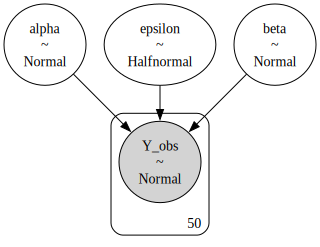

In [7]:
g = pm.model_to_graphviz(model1)
display(g)

In [8]:
# PyMC による単回帰モデル（sepal_length -> sepal_width）の定義
# -------------------------------------------------------------------
# 理論的には、観測ペア (X_i, Y_i) が
#   Y_i = α X_i + β + ε_i
#   ε_i ~ N(0, ε^2)
# という一次回帰モデルに従うと仮定している。
# ここでは α, β, ε を確率変数として扱うベイズ回帰モデルを構築する。


model2 = pm.Model()  # 1つのベイズモデルをまとめるコンテナを作成

with model2:
    # ---------------------------------------------------------------
    # 1. 観測データ X, Y を pm.Data としてモデルに登録
    # ---------------------------------------------------------------
    # pm.Data を使うことで、X / Y を「モデルの外から与えられる固定データ」
    # として扱うことができる。将来、事後予測や新しい入力値に対する更新
    # （pm.set_data）を行う際に、このラッパー経由で値を差し替え可能になる。
    # 単に numpy 配列をそのまま使うのではなく pm.Data を使うのは、
    # 「データは未知パラメータではなく、条件付きの既知量である」
    # というベイズモデリングの立場をコード上にも明示する狙いがある。
    X_data = pm.Data("X_data", X)
    Y_data = pm.Data("Y_data", Y)

    # ---------------------------------------------------------------
    # 2. 回帰係数 α, β の事前分布
    # ---------------------------------------------------------------
    # α, β はそれぞれ一次関数 Y = αX + β の「傾き」「切片」に対応する。
    #
    #   α ~ Normal(0, 10^2)
    #   β ~ Normal(0, 10^2)
    #
    # という広いガウス事前を置くことで、
    #   ・どの程度の傾き・切片にも事前には幅広く可能性を認める
    #   ・極端に大きな値は（Gaussian の裾で）やや抑制する
    # といった“弱情報的（weakly informative）”な事前となる。
    # これは「ほぼデータ駆動だが、数値的に暴れにくい」設定としてよく使われる。
    alpha = pm.Normal("alpha", mu=0.0, sigma=10.0)
    beta = pm.Normal("beta", mu=0.0, sigma=10.0)

    # ---------------------------------------------------------------
    # 3. 線形予測子 μ = αX + β の定義
    # ---------------------------------------------------------------
    # 観測 Y は、期待値が αX+β、誤差が正規分布に従うと仮定している。
    # この期待値部分を線形予測子（linear predictor）と呼び、
    #
    #   μ_i = α X_i + β
    #
    # という形をとる。ここでは μ を pm.Deterministic として登録している。
    #   ・理論的には μ は α, β, X から一意に決まる決定論的な量
    #   ・MCMC サンプルごとに μ の値を保存して、事後予測や可視化に使いたい
    # という理由から、「派生パラメータ」として明示的に保持している。
    mu = pm.Deterministic("mu", alpha * X_data + beta)

    # ---------------------------------------------------------------
    # 4. ノイズ（誤差項） ε のスケールに対する事前分布
    # ---------------------------------------------------------------
    # 回帰モデルでは、誤差 ε_i を
    #   ε_i ~ Normal(0, ε^2)
    # とみなすのが標準的であり、ここではその標準偏差 ε を未知パラメータ
    # として推論する。
    #
    #   ε ~ HalfNormal(1)
    #
    # は「0 以上の値のみをとる標準偏差」に対する事前分布であり、
    # 小さい値をやや好みつつも 1 以上の値も許容する“弱情報的”な事前である。
    # Normal(0, ε^2) のスケールパラメータに HalfNormal を置くのは、
    # 「負の標準偏差を排除しつつ、あまり強い先入観を入れない」
    # という実務上よく用いられる選択である。
    epsilon = pm.HalfNormal("epsilon", sigma=1.0)

    # ---------------------------------------------------------------
    # 5. 観測 Y に対する尤度（観測モデル）
    # ---------------------------------------------------------------
    # 最後に、観測された sepal_width (Y_data) が
    #
    #   Y_i | α, β, ε  ~  Normal( μ_i, ε^2 )
    #
    # に従うという仮定を pm.Normal で表現する。
    # ここで μ_i は上で定義した線形予測子、
    # ε は誤差の標準偏差である。
    #
    # これにより、ベイズ推論の枠組みでは
    #   p(α, β, ε | X, Y) ∝ p(Y | X, α, β, ε) p(α) p(β) p(ε)
    # という事後分布が定義され、pm.sample によって
    # その近似サンプルを得ることができる。
    obs = pm.Normal("obs", mu=mu, sigma=epsilon, observed=Y_data)

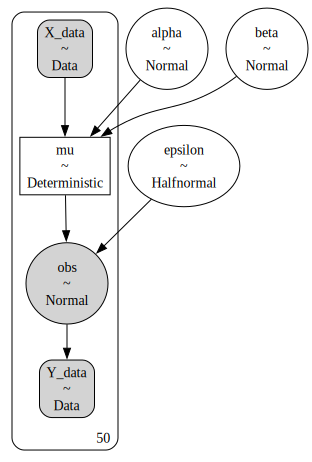

In [9]:
g = pm.model_to_graphviz(model2)
display(g)

In [10]:
with model2:
    idata2 = pm.sample(random_seed=42)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, epsilon]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


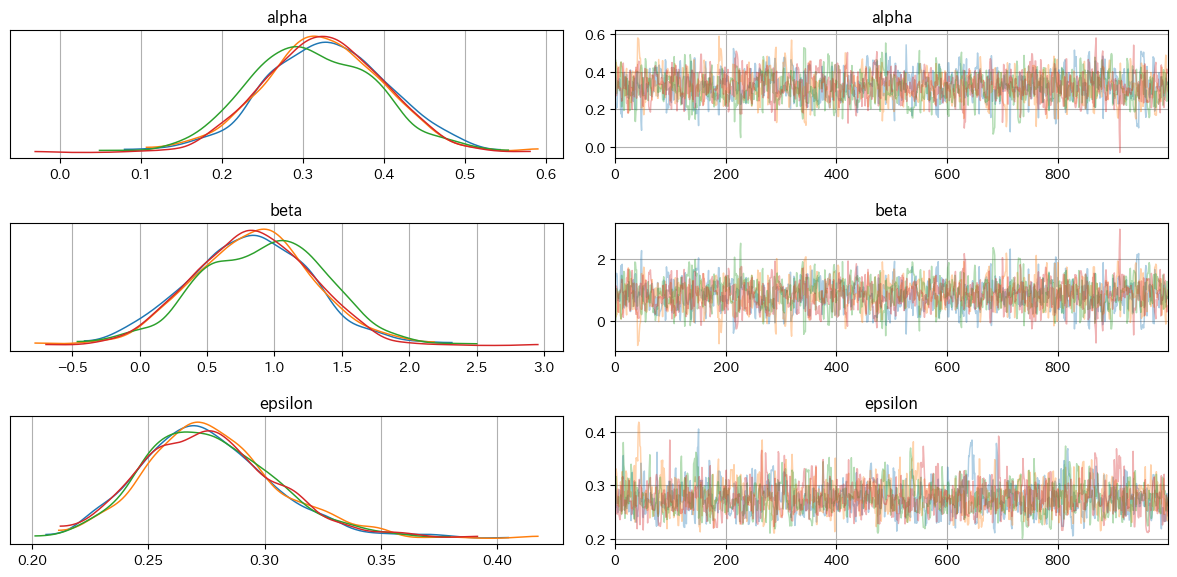

In [11]:
az.plot_trace(idata2, compact=False, var_names=["alpha", "beta", "epsilon"])
plt.tight_layout()

array([<Axes: title={'center': 'alpha'}>,
       <Axes: title={'center': 'beta'}>,
       <Axes: title={'center': 'epsilon'}>], dtype=object)

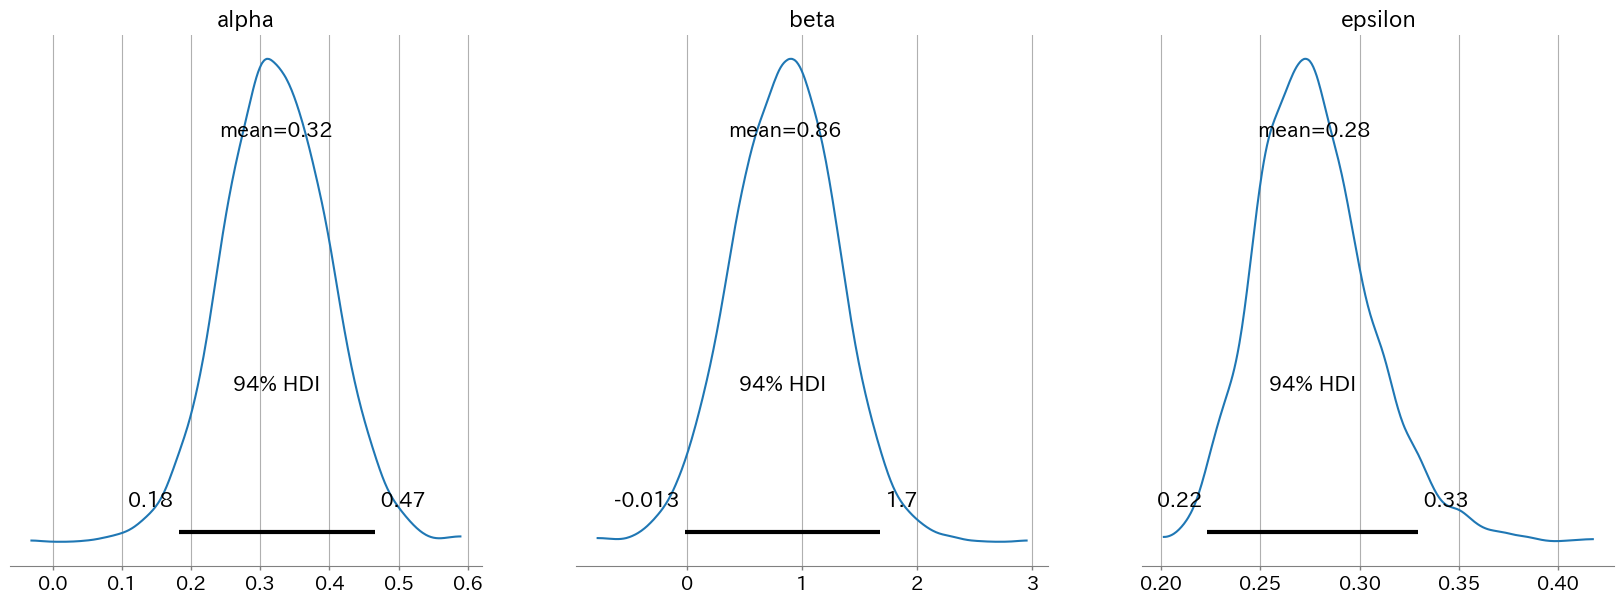

In [12]:
az.plot_posterior(idata2, var_names=["alpha", "beta", "epsilon"])

In [13]:
# xの２点をNumPy配列にする
x_values = np.array([X.min() - 0.1, X.max() + 0.1])
print(x_values, x_values.shape)

# サンプリング結果からalphaとbetaを取り出しshapeを加工する
alphas2 = idata2["posterior"]["alpha"].values.reshape(-1, 1)
betas2 = idata2["posterior"]["beta"].values.reshape(-1, 1)

# shapeの確認
print(alphas2.shape, betas2.shape)

# 2000パターンそれぞれで、２点の１次関数値の計算
y_preds = x_values * alphas2 + betas2
print(y_preds.shape)

[4.800 7.100] (2,)
(4000, 1) (4000, 1)
(4000, 2)


Text(0, 0.5, 'sepal_width')

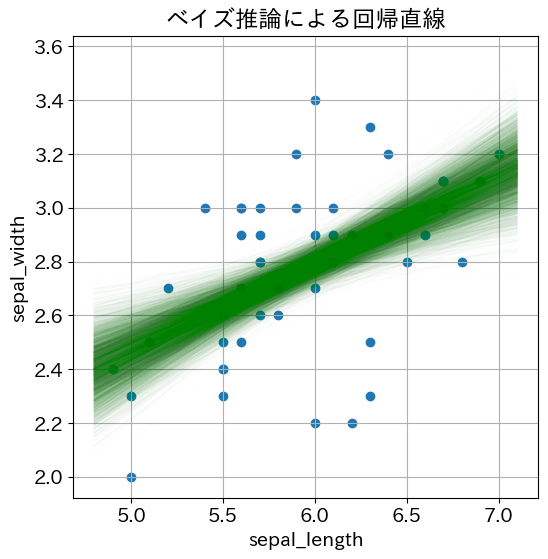

In [14]:
for y_pred in y_preds:
    plt.plot(x_values, y_pred, lw=1, alpha=0.01, c="g")
plt.scatter(X, Y)
plt.title("ベイズ推論による回帰直線")
plt.xlabel("sepal_length")
plt.ylabel("sepal_width")

In [15]:
import random

random.seed(42)
indexes = range(len(X))
sample_indexes = random.sample(indexes, 3)
print("インデックス値", sample_indexes)

# データ数を3個にする
X_less = X.iloc[sample_indexes]
Y_less = Y.iloc[sample_indexes]
print("xの値", X_less.values)
print("yの値", Y_less.values)

インデックス値 [40, 7, 1]
xの値 [5.500 4.900 6.400]
yの値 [2.600 2.400 3.200]


Text(0, 0.5, 'sepal_width')

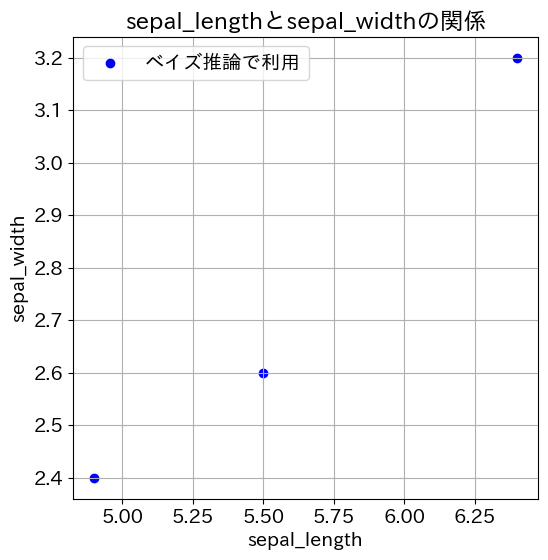

In [16]:
plt.title("sepal_lengthとsepal_widthの関係")
plt.scatter(X_less, Y_less, label="ベイズ推論で利用", c="b", marker="o")
plt.legend()
plt.xlabel("sepal_length")
plt.ylabel("sepal_width")

In [17]:
model3 = pm.Model()

with model3:
    # X, Yの観測値をConstantDataとして定義
    X_data = pm.Data("X_data", X_less)
    Y_data = pm.Data("Y_data", Y_less)

    # 確率変数alpha、betaの定義(一次関数の傾きと切片)
    alpha = pm.Normal("alpha", mu=0.0, sigma=10.0)
    beta = pm.Normal("beta", mu=0.0, sigma=10.0)

    # 平均値muの計算
    mu = pm.Deterministic("mu", alpha * X_data + beta)

    # 　誤差を示す確率変数epsilonの定義
    epsilon = pm.HalfNormal("epsilon", sigma=1.0)

    # 観測値を持つ確率変数はobsとして定義
    obs = pm.Normal("obs", mu=mu, sigma=epsilon, observed=Y_data)

    # サンプリング
    idata3 = pm.sample(draws=2000, tune=2000, random_seed=42, target_accept=0.995)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, epsilon]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 17 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


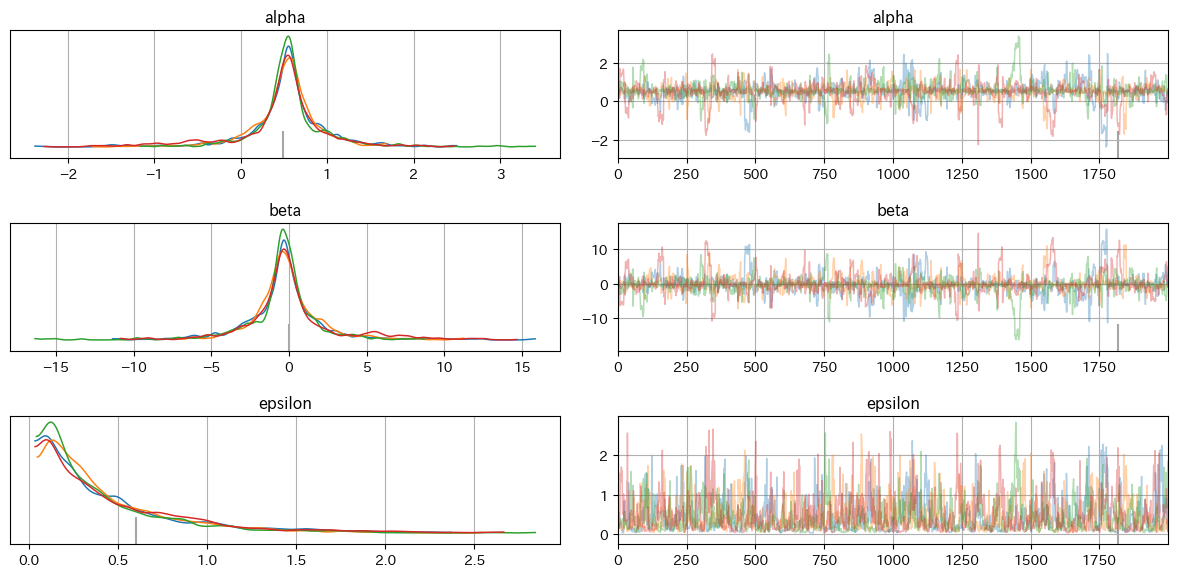

In [18]:
az.plot_trace(idata3, compact=False, var_names=["alpha", "beta", "epsilon"])
plt.tight_layout()

Text(0, 0.5, 'sepal_width')

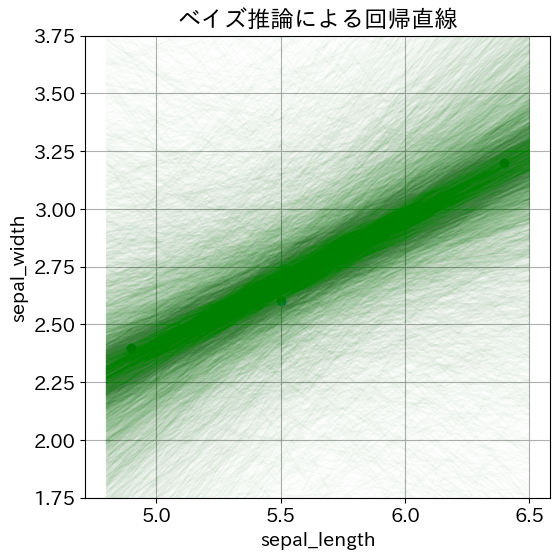

In [19]:
# xの２点をNumPy配列にする
x_values = np.array([X_less.min() - 0.1, X_less.max() + 0.1])

# サンプル値からalphaとbetaを取り出しshapeを加工する
alphas3 = idata3["posterior"]["alpha"].values.reshape(-1, 1)
betas3 = idata3["posterior"]["beta"].values.reshape(-1, 1)

# 2000パターンそれぞれで、２点の１次関数値の計算
y_preds = x_values * alphas3 + betas3

# 2000組の直線を散布図と同時表示
for y_pred in y_preds:
    plt.plot(x_values, y_pred, lw=1, alpha=0.01, c="g")
plt.scatter(X_less, Y_less)
plt.ylim(1.75, 3.75)
plt.title("ベイズ推論による回帰直線")
plt.xlabel("sepal_length")
plt.ylabel("sepal_width")